In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,Dropout,Activation,Bidirectional,Embedding,Dense,Flatten,GlobalMaxPooling1D,SpatialDropout1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from gensim.models import Word2Vec, KeyedVectors
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')
tf.__version__

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'2.6.0'

In [38]:
data_clean=pd.read_csv('/content/gdrive/MyDrive/clean_data.csv')

In [39]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

In [40]:
nltk.download('wordnet')
data_clean["Plot_clean"] = data_clean["Plot_clean"].apply(lambda text: lemmatize_text(text))
data_clean.head()
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
data_clean['Plot_clean'] = data_clean['Plot_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,Unnamed: 0,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,0,32501,2011,Vasthad,Telugu,Rajamithran,"Aadhi, Meera Nandan",drama,https://en.wikipedia.org/wiki/Ayyanar_(film),Prabha (Aadhi Pinisetty) is the eldest son of ...,0,prabha aadhi pinisetty eldest son family doe n...
1,1,48,1912,Petticoat Camp,American,Unknown,"William Garwood, Florence La Badie",comedy,https://en.wikipedia.org/wiki/Petticoat_Camp,"Only lasting 15 minutes, it is a light-hearted...",1,lasting minute lighthearted comedy battle sex ...
2,2,15091,2006,Talladega Nights: The Ballad of Ricky Bobby,American,Adam McKay,"Will Ferrell, John C. Reilly, Sacha Baron Cohen",comedy,https://en.wikipedia.org/wiki/Talladega_Nights...,Ricky Bobby is a man who grew up dreaming of g...,1,ricky bobby man grew dreaming going fast worki...
3,3,12831,1996,Skin & Bone,American,Everett Lewis,J. Wyatt,drama,https://en.wikipedia.org/wiki/Skin_%26_Bone_(f...,Skin & Bone is an episodic account of three Lo...,0,skin bone episodic account three los angelesar...
4,4,2870,1940,The Man I Married,American,Irving Pichel,"Joan Bennett, Francis Lederer",drama,https://en.wikipedia.org/wiki/The_Man_I_Married,"A successful American woman, art critic Carol ...",0,successful american woman art critic carol cab...


In [42]:
max_num_words=50000
max_seq_len=1000
tokenizer = Tokenizer(num_words=max_num_words,filters='!"#$&%()*+-./:;<=>?@[\]^_`{|}~',lower=True)
tokenizer.fit_on_texts((list(data_clean['Plot_clean'])))
sequences=tokenizer.texts_to_sequences((list(data_clean['Plot_clean'])))
word_index=tokenizer.word_index
print("unique tokens:",len(word_index))
# max_len=np.max([len(sequence) for sequence in sequences])
print("Max length:",max_seq_len)
data = pad_sequences(sequences, maxlen=max_len)
print("Shape of data tensor:",data.shape)

unique tokens: 114645
Max length: 1000
Shape of data tensor: (12608, 1488)


In [43]:
labels=np.asarray(data_clean['GenreID'])
labels=to_categorical(labels,num_classes=4)
print('Label:',labels.shape)
labels

Label: (12608, 4)


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [44]:
X_train,X_val,y_train,y_val=train_test_split(data,labels,test_size=0.10,random_state=42)

In [45]:
embedding_dim=700
model=Sequential()
model.add(Embedding(input_dim=max_num_words,output_dim=embedding_dim,input_length=data.shape[1]))
model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(Dropout(0.3))
model.add(LSTM(32,kernel_regularizer=l2(0.0001),return_sequences=True))
model.add(Dropout(0.4))
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-3),metrics=['categorical_accuracy'])
model.summary()
# 32,kernel_regularizer=l2(0.001),input_shape=(X_train.shape[1:]),activation='tanh'

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1488, 700)         35000000  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1488, 700)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1488, 32)          93824     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1488, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 47616)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 190468    
Total params: 35,284,292
Trainable params: 35,284,292
Non-trainable params: 0
__________________________________________

In [46]:
filepath="MovieGenrePredictionUsingPlotSummariesmodel1.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)
callbacks_list = [checkpoint]
len(X_train),len(X_val)

(11347, 1261)

In [47]:
history=model.fit(X_train,y_train, epochs=3, callbacks=callbacks_list, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/3
89/89 [==============================] - 575s 6s/step - loss: 0.9434 - categorical_accuracy: 0.5851 - val_loss: 0.6645 - val_categorical_accuracy: 0.7335
Epoch 2/3
89/89 [==============================] - 569s 6s/step - loss: 0.3543 - categorical_accuracy: 0.8745 - val_loss: 0.7361 - val_categorical_accuracy: 0.7240
Epoch 3/3
89/89 [==============================] - 572s 6s/step - loss: 0.1041 - categorical_accuracy: 0.9730 - val_loss: 1.1611 - val_categorical_accuracy: 0.6963


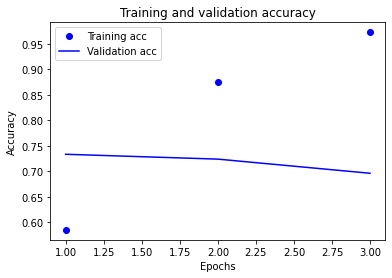

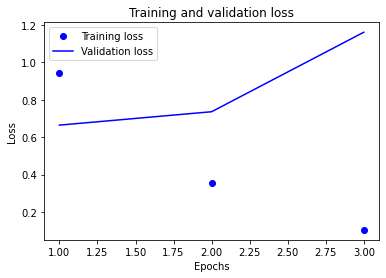

In [48]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
from tensorflow.python.keras.models import load_model

best_model = load_model('MovieGenrePredictionUsingPlotSummariesmodel1.h5')

In [50]:
batch_size=64
steps_test=int(len(X_val)/batch_size)
result = best_model.evaluate(X_val, y_val, steps=steps_test,verbose=1)
print("Validation-set accuracy: {0:.2%}".format(result[1]))

19/19 [==============================] - 14s 709ms/step - loss: 0.6645 - categorical_accuracy: 0.7335
Validation-set accuracy: 73.35%


In [51]:
best_model.save('fypmodel{:.2%}.h5'.format(result[1]))
name='fypmodel{:.2%}.tflite'.format(result[1])
converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(name, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpc53vd9h7/assets


INFO:tensorflow:Assets written to: /tmp/tmpc53vd9h7/assets


In [52]:
preds = best_model.predict(X_val, batch_size=128,verbose=1)
preds=np.around(preds)

orig_val_labels=np.argmax(y_val,axis=1)
predicted_labels=np.argmax(preds,axis=1)

orig_val_labels=np.reshape(orig_val_labels,(len(X_val),1))
predicted_labels=np.reshape(predicted_labels,(len(X_val),1))

print(predicted_labels.shape)
print(orig_val_labels.shape)

10/10 [==============================] - 12s 1s/step
(1261, 1)
(1261, 1)


<Figure size 432x288 with 0 Axes>

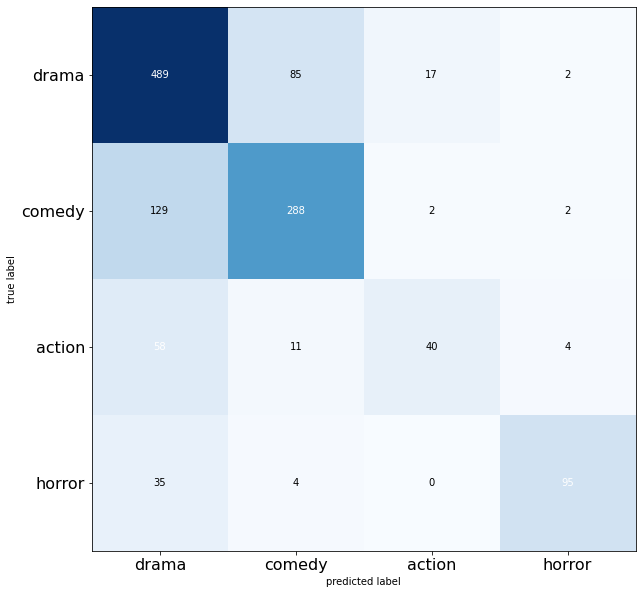

In [53]:
%matplotlib inline
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_val_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(15,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.yticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.show()

In [54]:
MainGenres=['drama','comedy','action','horror']
print(classification_report(orig_val_labels,predicted_labels,target_names=MainGenres))

              precision    recall  f1-score   support

       drama       0.69      0.82      0.75       593
      comedy       0.74      0.68      0.71       421
      action       0.68      0.35      0.47       113
      horror       0.92      0.71      0.80       134

    accuracy                           0.72      1261
   macro avg       0.76      0.64      0.68      1261
weighted avg       0.73      0.72      0.72      1261

